## Multi-classification problem


In [3]:
# Uncomment the next line to install packages
#!pip install torch torchvision matplotlib pandas seaborn requests 

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import mlflow
import requests
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt

%matplotlib inline

## Load Data

PyTorch provides two powerful data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as prepare your own data. `Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the Dataset to enable easy access to the samples.

### USPS Dataset
* Handwritten digits with 10 classes
* 16x16 pixels for each image 
* 6 000 data examples in training set, 1 291 examples in validation set, 2 007 in test set

In [5]:
raw_data_path = '../data/raw/'

# url = 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.bz2'
# r = requests.get(url, allow_redirects=True)
# if not os.path.isdir(raw_data_path + 'USPS/'):
#     os.mkdir('USPS/')
# open('USPS/usps.bz2', 'wb').write(r.content)

In [102]:
# Loading USPS dataset from torchvision.dataset
dataset = torchvision.datasets.USPS(root= raw_data_path + 'USPS/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=False)

In [103]:
# Get info from dataset
dataset

Dataset USPS
    Number of datapoints: 7291
    Root location: ../data/raw/USPS/
    StandardTransform
Transform: ToTensor()

In [8]:
# Obtain the inputs and targets:
inputs = dataset.data
targets = dataset.targets

In [9]:
# Let's look at a data point
sample_index = 88

data_sample = dataset.data[sample_index]
target_sample = dataset.targets[sample_index]
print("Sample type and shape : ",type(data_sample),data_sample.shape)
print("Label type and value : " ,type(target_sample),target_sample)

Sample type and shape :  <class 'numpy.ndarray'> (16, 16)
Label type and value :  <class 'int'> 9


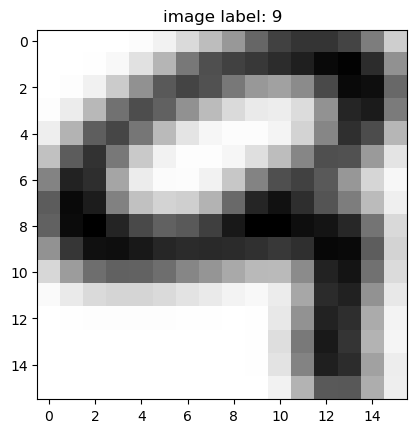

In [11]:
sample_index = 88
plt.imshow(dataset.data[sample_index], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("image label: %d" % dataset.targets[sample_index])
plt.show()

## Pytorch Tensor

Pytorch Documentation : https://pytorch.org/docs/stable/index.html

In [12]:
tensor_data_point = torch.tensor(data_sample)
print("Tensor type :",type(tensor_data_point),", and shape : ",tensor_data_point.shape)

Tensor type : <class 'torch.Tensor'> , and shape :  torch.Size([16, 16])


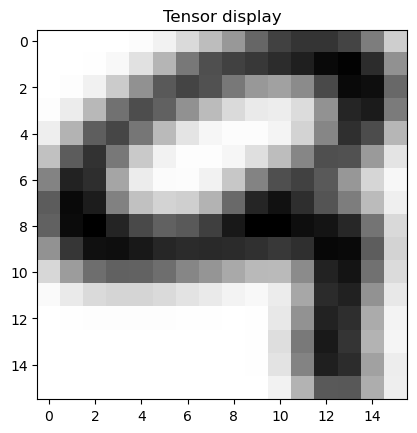

In [13]:
# Pyplot can manage torch Tensors
plt.imshow(tensor_data_point, cmap=plt.cm.gray_r)
plt.title("Tensor display")
plt.show()

In [14]:
# split the dataset to training and validation sets
generator1 = torch.Generator().manual_seed(42)
train_set, val_set = random_split(dataset, [6000, 1291], generator=generator1)

## Build your Neural Network
The `torch.nn` namespace provides all the building blocks you need to create your own neural network such as fully connected layers or convolutional layers etc. We define our neural network by subclassing `nn.Module`, and the neural network layers are initialized in **\__init\__**. Every `nn.Module` subclass implements the operations on input data in the **forward** method.

Inheritance in Python (https://www.programiz.com/python-programming/inheritance)

In [17]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        # We allocate space for the weights
        self.l1 = nn.Linear(16*16, 100)
        self.l2 = nn.Linear(100, 10)
        # Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs): # Called when we apply the network 
        h = F.relu(self.l1(inputs)) # You can put anything, as long as its Pytorch functions
        outputs = F.softmax(self.l2(h), dim=1)# Use softmax as the activation function for the last layer
        return outputs

Description of AutoGrad (https://pytorch.org/docs/stable/notes/autograd.html)

### Instantiation and forward call

In [18]:
# We initialize the Model class
my_model = Model() # it calls the init method
print(" - What is the type of my_model ?",type(my_model))
print("="*50)
print(" - Description of the internal of the Network :",my_model)
print("="*50)
print(" - Content of the first Layer :", my_model.l1.weight,)

 - What is the type of my_model ? <class '__main__.Model'>
 - Description of the internal of the Network : Model(
  (l1): Linear(in_features=256, out_features=100, bias=True)
  (l2): Linear(in_features=100, out_features=10, bias=True)
)
 - Content of the first Layer : Parameter containing:
tensor([[ 0.0090, -0.0487, -0.0274,  ..., -0.0581, -0.0600, -0.0167],
        [-0.0501, -0.0002,  0.0164,  ...,  0.0046,  0.0611, -0.0308],
        [ 0.0283, -0.0254, -0.0189,  ..., -0.0139,  0.0464, -0.0421],
        ...,
        [-0.0428,  0.0346,  0.0520,  ..., -0.0139, -0.0571, -0.0579],
        [-0.0363,  0.0114, -0.0457,  ...,  0.0363, -0.0068, -0.0359],
        [ 0.0623,  0.0525, -0.0282,  ...,  0.0619,  0.0011,  0.0624]],
       requires_grad=True)


In [19]:
# Shape of the Linear Layer 
print("A :",my_model.l1.weight.shape," b : ",my_model.l1.bias.shape)

A : torch.Size([100, 256])  b :  torch.Size([100])


In [21]:
# Let's explore the forward pass
example_batch_size = 3
example_loader = DataLoader(dataset, batch_size=example_batch_size, shuffle=True)

for images,labels in example_loader:
    print("Original tensor shape",images.shape)
    print("="*50)
    print("Impact of the view method",images.view(example_batch_size,-1).shape)
    print("="*50)
    example_output = my_model(images.view(example_batch_size,-1))
    print("Shape of the output",example_output.shape)
    print("="*50)
    print("Predictions for the first image :",example_output[0].detach())
    print("="*50)
    print("Sum of all outputs : ",torch.sum(example_output[0])) # You should use detach !
    break

Original tensor shape torch.Size([3, 1, 16, 16])
Impact of the view method torch.Size([3, 256])
Shape of the output torch.Size([3, 10])
Predictions for the first image : tensor([0.1029, 0.1111, 0.1062, 0.1063, 0.0842, 0.0973, 0.0953, 0.0982, 0.0998,
        0.0987])
Sum of all outputs :  tensor(1., grad_fn=<SumBackward0>)


In [25]:
# Example of One Hot Encoding

labels_one_hot = torch.FloatTensor(example_batch_size, 10)
labels_one_hot.zero_()
print("Original Labels : ",labels.detach())
print("="*50)
# print(labels.shape, labels.view(-1, 1).shape, labels.view(-1, 1))
print("One Hot encoding :",labels_one_hot.scatter_(1, labels.view(-1, 1), 1).detach())

Original Labels :  tensor([1, 9, 6])
One Hot encoding : tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])


## Train your Model

In [26]:
# Create the model: 
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [29]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train() # Indicates to the network we are in training mode
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            y_pre = model(images.view(batch_size, -1)) 
            #reshape the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
            
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(batch_size, 10)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
           
            
            loss = criterion(y_pre, labels_one_hot) #Real number
            optimizer.zero_grad() # Set all the parameters gradient to 0
            loss.backward() # Computes  dloss/da for every parameter a which has requires_grad=True
            optimizer.step() # Updates the weights 
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [30]:
train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

Epoch [1/10], Loss: 0.0845
Epoch [2/10], Loss: 0.0702
Epoch [3/10], Loss: 0.0565
Epoch [4/10], Loss: 0.0426
Epoch [5/10], Loss: 0.0318
Epoch [6/10], Loss: 0.0241
Epoch [7/10], Loss: 0.0193
Epoch [8/10], Loss: 0.0164
Epoch [9/10], Loss: 0.0146
Epoch [10/10], Loss: 0.0133


Text(0.5, 1.0, 'Visualization of convergence')

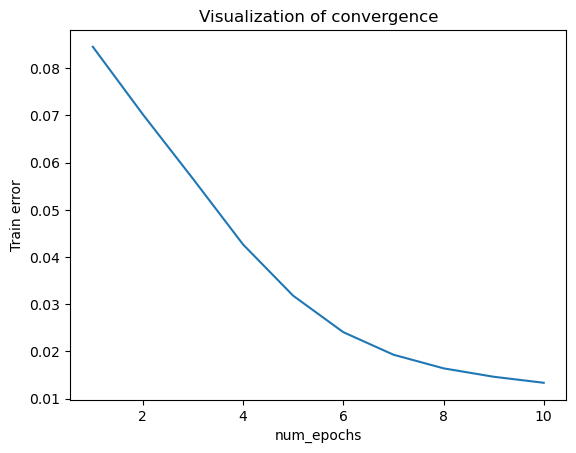

In [31]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

### Evaluate the Model on validation set

In [33]:
# Calculate the accuracy to evaluate the model
def accuracy(dataset, model):

    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            images = images.view(-1, 16*16)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  
            correct += (predicted == labels).sum()
    accuracy = 100*correct.item()/ len(dataset)
    print('Accuracy of the model : {:.2f} %'.format(100*correct.item()/ len(dataset)))
    return accuracy

In [34]:
accuracy(val_set, model)

Accuracy of the model : 92.10 %


In [62]:
val_index = 66

(image, label) = val_set[val_index]
output = model(image.view(-1, 16*16))
_, prediction = torch.max(output.data, 1)

plt.imshow(image.view(16, 16), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Prediction label: %d" % prediction)

### Exercise 1: Impact of the architecture of the model
Define your own class `Model` to improve the predictions:

* The convolutional layer can be a good choice to deal with images. Replace nn.Linear with [nn.Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d).
* Try to add more layers (1, 2, 3, more ?)
* Change the number of neurons in hidden layers (5, 10, 20, more ?)
* Try different activation functions such as [sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.

In [96]:
# Calculate the accuracy to evaluate the model
def accuracy2d(dataset, model):

    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  
            correct += (predicted == labels).sum()
    accuracy = 100*correct.item()/ len(dataset)
    return accuracy

In [86]:
# define a function for training
MLF_CONFIG_DEF = {
    'name_experiment' : 'test_name',
    'run_name' : 'test_run',
    'description' : 'This is the default config.'
}

def train_mlflow(num_epochs, batch_size, criterion, optimizer, model, train_dataset, test_dataset, training_params = {}, model_params = {}, exp_config = MLF_CONFIG_DEF):
    # MLflow configuration
    name_experiment =  exp_config['name_experiment']
    mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
    mlflow.set_experiment(name_experiment)
    if mlflow.get_experiment_by_name(name_experiment) is None:
        mlflow.create_experiment(name_experiment)
    experiment_id = mlflow.get_experiment_by_name(name_experiment).experiment_id

    # Start run
    with mlflow.start_run(experiment_id=experiment_id,
                      run_name=exp_config['run_name'],
                      description=exp_config['description']):
        mlflow.log_param('epochs', num_epochs)
        mlflow.log_param('batch_size', batch_size)
        mlflow.log_params(training_params)
        mlflow.log_params(model_params)


        train_error = []
        train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
        model.train() # Indicates to the network we are in training mode
        for epoch in range(num_epochs):
            epoch_average_loss = 0.0
            for (images, labels) in train_loader:
                y_pre = model(images) 
            
                # One-hot encoding or labels so as to calculate MSE error:
                labels_one_hot = torch.FloatTensor(batch_size, 10)
                labels_one_hot.zero_()
                labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
            
                loss = criterion(y_pre, labels_one_hot) #Real number
                optimizer.zero_grad() # Set all the parameters gradient to 0
                loss.backward() # Computes  dloss/da for every parameter a which has requires_grad=True
                optimizer.step() # Updates the weights 
                epoch_average_loss += loss.item() * batch_size / len(dataset)
            train_error.append(epoch_average_loss)
        
            #Test
            test_accuracy = accuracy2d(test_dataset, model)
            print('Epoch [{}/{}] \t Train loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
            print('\t Test accuracy: {:.4f}'.format(test_accuracy))
        # Log last metrics 
        # TODO : log best metrics ?
        mlflow.log_metric('loss', loss.item())
        mlflow.log_metric('accuracy', test_accuracy)

    return train_error

In [81]:
class ConvModel(nn.Module):
    
    def __init__(self, n_hidden = 1, k_size = 5, activation_fn = F.relu):
        super(ConvModel, self).__init__()
        self.n_hidden = n_hidden
        self.layer_width = k_size
        # We allocate space for the weights
        self.input_layer = nn.Conv2d(1, 1, k_size, padding='same')
        self.conv_layers = nn.ModuleList([nn.Conv2d(1, 1, k_size, padding='same') for i in range(n_hidden)])
        self.activation = activation_fn
        self.l2 = nn.Linear(16*16, 10)
        # Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs): # Called when we apply the network 
        h = self.activation(self.input_layer(inputs))
        for conv_layer in self.conv_layers :
            h = self.activation(conv_layer(h))
        h = torch.flatten(h, start_dim = 1)
        outputs = F.softmax(self.l2(h), dim=1)# Use softmax as the activation function for the last layer
        return outputs

In [100]:
# Test model
# description
model = ConvModel()
print(" - What is the type of model ?",type(model))
print("="*50)
print(" - Description of the internal of the Network :",model)
print("="*50)
print(" - Content of the first Layer :", model.input_layer.weight)

# forward pass
example_batch_size = 3
example_loader = DataLoader(dataset, batch_size=example_batch_size, shuffle=True)

for images,labels in example_loader:
    example_output = model(images)


 - What is the type of model ? <class '__main__.ConvModel'>
 - Description of the internal of the Network : ConvModel(
  (input_layer): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv_layers): ModuleList(
    (0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=same)
  )
  (l2): Linear(in_features=256, out_features=10, bias=True)
)
 - Content of the first Layer : Parameter containing:
tensor([[[[-0.1730, -0.1800,  0.0466, -0.1262,  0.1782],
          [-0.1598,  0.0696, -0.1541, -0.1028,  0.0178],
          [ 0.0719, -0.1474, -0.1660,  0.0602, -0.0559],
          [ 0.0928, -0.1114, -0.1545,  0.0802,  0.1979],
          [-0.0772,  0.1886, -0.1918, -0.0490,  0.1438]]]], requires_grad=True)


In [119]:
# Training (with MLflow)
# Dataset :
generator1 = torch.Generator().manual_seed(42)
train_set, val_set = random_split(dataset, [6000, 1291], generator=generator1)

# Model parameters :
model_params = {
    'n_hidden' : 1,
    'k_size' : 5}
torch.manual_seed(42)
model = ConvModel(**model_params, activation_fn= F.relu)
model_params['activation_fn'] = 'relu'

# Hyperparameters for training: 
num_epochs = 10
batch_size = 10
lr = 0.1
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
training_params = {
    'criterion' : 'MSELoss',
    'optimizer' : 'SGD',
    'lr' : lr
}

exp_config = {
    'name_experiment' : f'Conv_h{model_params["n_hidden"]}_k{model_params["k_size"]}',
    'run_name' : 'test_run',
    'description' : ''

}
train_error = train_mlflow(num_epochs, batch_size, criterion, optimizer, model, train_set, val_set, training_params, model_params, exp_config)

Epoch [1/10] 	 Train loss: 0.0739
	 Test accuracy: 16.4988
Epoch [2/10] 	 Train loss: 0.0738
	 Test accuracy: 16.4988
Epoch [3/10] 	 Train loss: 0.0737
	 Test accuracy: 16.4988
Epoch [4/10] 	 Train loss: 0.0737
	 Test accuracy: 16.4988
Epoch [5/10] 	 Train loss: 0.0736
	 Test accuracy: 16.4988
Epoch [6/10] 	 Train loss: 0.0736
	 Test accuracy: 16.4988
Epoch [7/10] 	 Train loss: 0.0735
	 Test accuracy: 16.4988
Epoch [8/10] 	 Train loss: 0.0735
	 Test accuracy: 16.4988
Epoch [9/10] 	 Train loss: 0.0735
	 Test accuracy: 16.4988
Epoch [10/10] 	 Train loss: 0.0735
	 Test accuracy: 16.4988


Text(0.5, 1.0, 'Visualization of convergence')

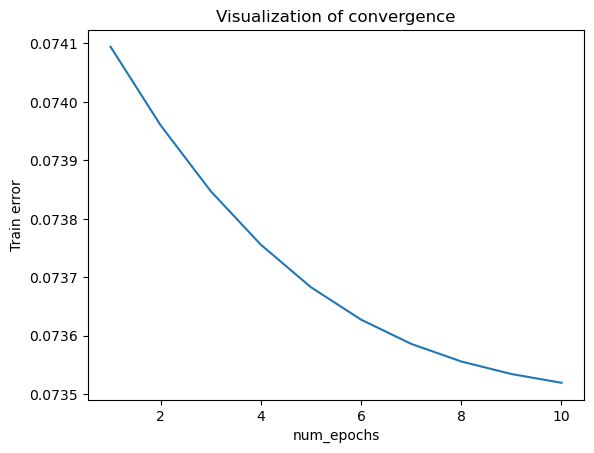

In [114]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

In [75]:
# !mlflow ui --port 5002

^C


### Exercise 2: Impact of the optimizer
Retrain the model by using different parameters of the optimizer; you can change its parameters in the cell initializing it, after the definition of your model.

* Use different batch sizes, from 10 to 1 000 for instance
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

### Exercise 3: Impact of the loss function
The MSE error is rarely used in this case. The cross entropy loss can be a better choice for multi-classification problems. In pytorch, the cross entropy loss is defined by [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss). Replace the MSE loss by this one to observe its impact.

**Note:** In order to use nn.CrossEntropyLoss correctly, don't add an activation function to the last layer of your network. And one-hot encoding is no longer needed to calculate the loss, delete the encoding procedures in function `train`.   

### Exercise 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [1]:
import requests

url = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.t.bz2'
r = requests.get(url, allow_redirects=True)
open('USPS/usps.t.bz2', 'wb').write(r.content)

299

In [ ]:
# Loading MNIST test set from torchvision.dataset
test_set = torchvision.datasets.USPS(root='USPS/',
                                         train=False,
                                         transform=transforms.ToTensor(),
                                         download=False)

In [ ]:
accuracy(test_set, model)